In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../../")
import copy
import os
import logging
from src.utils import logging_utils
from src import functional
from src.models import ModelandTokenizer
# from src.data import load_relation
import json

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

In [3]:
RESULTS_DIR = os.path.join("../../", "results")
FIGURS_DIR = os.path.join("../../", "Figures")

MODEL = "mamba-2.8b" # "mamba-2.8b" | "pythia-2.8b-deduped"

causal_tracing_dir = os.path.join(RESULTS_DIR, "causal_tracing_aie", MODEL)

hooks = os.listdir(causal_tracing_dir)
hooks

['residual', 'ssm_after_ssm', 'after_down_proj', 'mlp_after_silu']

In [6]:
from src.tracing import average_indirect_effects
from src.plotting import plot_trace_heatmap
from typing import Literal

def load_indirect_effects(
    model: str,
    hook: Literal[
        "residual", 
        "ssm_after_ssm", "mlp_after_silu", "after_down_proj", # Mamba
        "mlp", "attn" # Pythia
    ] = "mlp_after_silu", 
):
    relation_files = os.listdir(os.path.join(causal_tracing_dir, hook))

    aie_all = {}

    for relation_file in relation_files:

        with open(os.path.join(causal_tracing_dir, hook, relation_file), "r") as f:
            relation_ie_all = json.load(f)
        
        print(f"{relation_file} - {len(relation_ie_all.keys())} samples")

        for k, v in relation_ie_all.items():
            aie_all[f"{k}_{relation_file}_{hook}"] = v

        relation_aie = average_indirect_effects(relation_ie_all, relative_recovery = True)
        # plot_trace_heatmap(
        #     relation_aie, 
        #     savepdf=os.path.join(save_dir, f"{relation_file}.pdf"),
        #     modelname="Mamba-2.8b"
        # )
    return aie_all

country_capital_city.json - 17 samples
person_plays_pro_sport.json - 150 samples
company_hq.json - 150 samples
landmark_in_country.json - 150 samples
company_ceo.json - 34 samples
person_occupation.json - 51 samples
product_by_company.json - 150 samples
person_native_language.json - 150 samples
place_in_city.json - 100 samples
952
2024-04-04 12:19:09 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-04-04 12:19:09 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-04-04 12:19:09 matplotlib.font_manager DEBUG    findfont: Matching Times New Roman:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-04-04 12:19:09 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/home/local_arnab/miniconda3/envs/relations/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretc

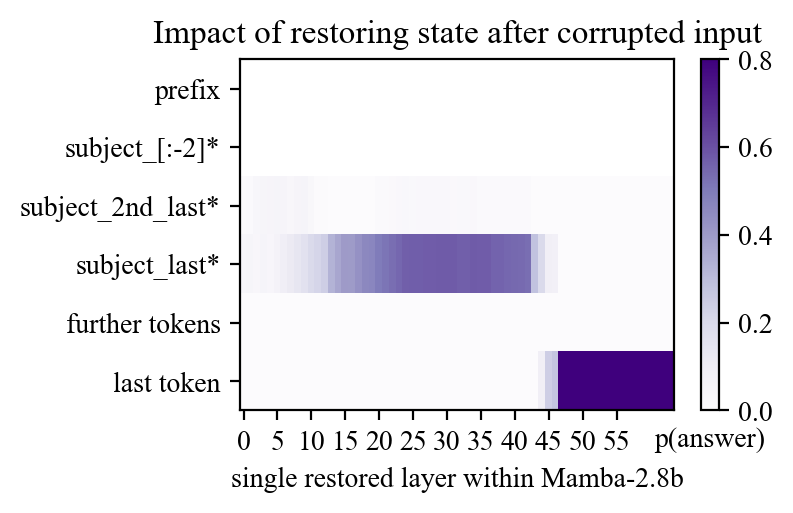

In [7]:
hook = "residual"
save_dir = os.path.join(FIGURS_DIR, "causal_tracing_aie", MODEL, hook)

ie_residual = load_indirect_effects(MODEL, hook)

print(len(ie_residual.keys()))

aie = average_indirect_effects(ie_residual, relative_recovery = True)
plot_trace_heatmap(
    aie, 
    savepdf=os.path.join(save_dir, f"0_{hook}_tracing.pdf"),
    modelname="Mamba-2.8b", 
    scale_range=(0.0, 0.8) if hook == "residual" else (0.0, 0.8)
)

In [9]:
ie_O = load_indirect_effects(MODEL, "after_down_proj")
print("o samples:", len(ie_O.keys()))
aie_O = average_indirect_effects(ie_O, relative_recovery = True)

ie_s = load_indirect_effects(MODEL, "ssm_after_ssm")
print("s samples:", len(ie_s.keys()))
aie_s = average_indirect_effects(ie_s, relative_recovery = True)

ie_g = load_indirect_effects(MODEL, "mlp_after_silu")
print("g samples:", len(ie_g.keys()))
aie_g = average_indirect_effects(ie_g, relative_recovery = True)

country_capital_city.json - 17 samples
person_plays_pro_sport.json - 150 samples
company_ceo.json - 9 samples
person_occupation.json - 51 samples
place_in_city.json - 99 samples
o samples: 326
country_capital_city.json - 16 samples
person_plays_pro_sport.json - 136 samples
company_hq.json - 150 samples
landmark_in_country.json - 150 samples
person_occupation.json - 51 samples
place_in_city.json - 98 samples
s samples: 601
country_capital_city.json - 16 samples
person_plays_pro_sport.json - 137 samples
company_hq.json - 150 samples
landmark_in_country.json - 150 samples
person_occupation.json - 52 samples
place_in_city.json - 99 samples
g samples: 604


In [18]:
subtract = {}

for k in aie_O.keys():
    if k == "scores":
        subtract[k] = aie_O[k] - aie_s[k] - aie_g[k]
    elif k == "kind":
        subtract[k] = "subtract"
    else:
        subtract[k] = aie_O[k]

2024-04-04 12:29:07 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f4a8b7a5480>
2024-04-04 12:29:07 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-04-04 12:29:07 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-04-04 12:29:07 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-04-04 12:29:07 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-04-04 12:29:07 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-04-04 12:29:07 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-04-04 12:29:07 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.
2024-04-04 12:29:07 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-04-04

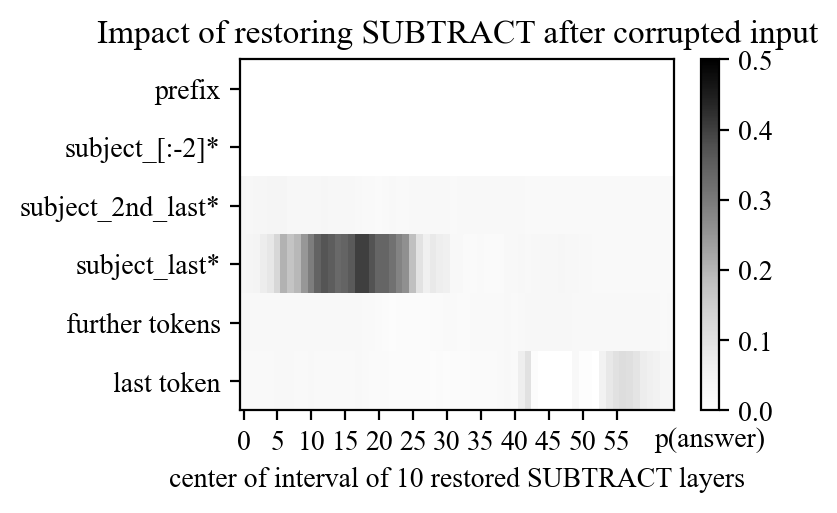

In [21]:
plot_trace_heatmap(
    subtract, 
    savepdf=os.path.join(save_dir, f"0_subtract_tracing.pdf"),
    modelname="Mamba-2.8b", 
    scale_range=(0.0, 0.5)
)

In [22]:
save_dir

'../../Figures/causal_tracing_aie/mamba-2.8b/residual'